In [302]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from moabb.datasets import BNCI2014001
from moabb.paradigms import (LeftRightImagery, MotorImagery,
                             FilterBankMotorImagery)

from RandSamp import getSamples, getSamplOrig
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from pyriemann.clustering import Kmeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

In [2]:
# Define colores
esmeralda = "#2ecc71"
belize = "#2980b9"
pome = "#c0392b"
ameth = "#9b59b6"
sun = "#f1c40f"
pumpkin = "#d35400"

palette = ListedColormap([esmeralda, belize, pome, ameth])
# Configuración de matplotlib
#plt.rcParams["font.family"] = "Palatino Linotype"
plt.rcParams["font.size"] = 10
plt.rcParams["font.weight"] = "regular"
plt.rcParams['font.family'] = 'serif'

#pal = sns.color_palette([esmeralda, belize, pome, ameth])

In [376]:
dataset = BNCI2014001()

# Cargar el paradigma a usar
paradigm = MotorImagery(n_classes=4,
                    fmin=8,
                    fmax=35,
                    tmin=-0.2,
                    tmax=4.5)
                    
X, y, metadata = paradigm.get_data(
dataset=dataset, subjects=[1])
mxx = np.max(X) / 5
X = (X / mxx)

Choosing from all possible events


In [377]:
encoder = LabelEncoder()
encoder.fit(y)
y_enc = encoder.transform(y)

In [378]:
subj = 1

X_train = X[(metadata["subject"]==subj) & (metadata["session"]=="session_T")]
y_train = y_enc[(metadata["subject"]==subj) & (metadata["session"]=="session_T")]

X_test = X[(metadata["subject"]==subj) & (metadata["session"]=="session_E")]
y_test = y_enc[(metadata["subject"]==subj) & (metadata["session"]=="session_E")]

In [379]:
X2 = np.load("X_EEG.npy")
y2 = np.load("y_EEG.npy")
y2_enc = encoder.transform(y2)
metadata2 = pd.read_csv("metadata_EEG.csv")
print(X2.shape)

X2 = (X2 / mxx)

X_train2 = X2[(metadata2["subject"]==subj) & (metadata2["session"]=="session_T")]
y_train2 = y2_enc[(metadata2["subject"]==subj) & (metadata2["session"]=="session_T")]

X_test2 = X2[(metadata2["subject"]==subj) & (metadata2["session"]=="session_E")]
y_test2 = y2_enc[(metadata2["subject"]==subj) & (metadata2["session"]=="session_E")]

(5184, 22, 1001)


In [380]:
samples, targets = getSamples(X_train, y_train, samples=30, ruido="eog", ns=50000)
print(samples.shape)

(120, 22, 1000)


In [381]:
pipe = Pipeline([("cov", Covariances()), ("ts", TangentSpace()), ("clf", DTC(max_depth=6))])

N = 20
ensemble = [Pipeline([("cov", Covariances()), ("ts", TangentSpace()), ("clf", LogisticRegression(solver='lbfgs', C=0.09))]) for i in range(N)]

for i in range(N):
    samples, targets = getSamples(X_train, y_train,
                                 samples=288,
                                 ruido="eog",
                                 ns=1000)
    ensemble[i].fit(samples, np.ravel(targets))
    #plt.plot(samples[0, 0])
    #print(targets[0])
    

In [382]:
pipe.fit(samples, np.ravel(targets))

Pipeline(steps=[('cov', Covariances()), ('ts', TangentSpace()),
                ('clf', DecisionTreeClassifier(max_depth=6))])

In [383]:
proba = ensemble[0].predict_proba(X_train2)
for i in range(1, N):
    proba += ensemble[i].predict_proba(X_train2)
y_hat = np.argmax(proba, 1)
print(proba.shape)
print(y_hat.shape)

(288, 4)
(288,)


In [384]:
#targ_hat = ensemble[0].predict(samples)
#print(classification_report(np.ravel(targets), targ_hat))

In [385]:
# Conjunto de Entrenamiento
#y_hat2 = ense.predict(X_train2)
print(classification_report(y_train2, y_hat))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91        72
           1       0.95      0.96      0.95        72
           2       0.91      0.97      0.94        72
           3       0.96      0.96      0.96        72

    accuracy                           0.94       288
   macro avg       0.94      0.94      0.94       288
weighted avg       0.94      0.94      0.94       288



In [386]:
proba = ensemble[0].predict_proba(X_test2)
for i in range(1, N):
    proba += ensemble[i].predict_proba(X_test2)
y_hat = np.argmax(proba, 1)

In [387]:
#y_hat = pipe.predict(X_test)
print(classification_report(y_test2, y_hat))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78        72
           1       0.82      0.92      0.87        72
           2       0.95      0.85      0.90        72
           3       0.80      0.78      0.79        72

    accuracy                           0.83       288
   macro avg       0.84      0.83      0.83       288
weighted avg       0.84      0.83      0.83       288



In [353]:
# Comparación con modelo simple
pipe2 = Pipeline([("cov", Covariances()), ("ts", TangentSpace()), ("clf", LogisticRegression(solver='lbfgs', C=0.09))])
pipe2.fit(X_train2, y_train2)

Pipeline(steps=[('cov', Covariances()), ('ts', TangentSpace()),
                ('clf', LogisticRegression(C=0.09))])

In [354]:
y_hat = pipe2.predict(X_train2)
print(classification_report(y_train2, y_hat))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91        72
           1       0.95      0.96      0.95        72
           2       0.92      0.97      0.95        72
           3       0.92      0.99      0.95        72

    accuracy                           0.94       288
   macro avg       0.94      0.94      0.94       288
weighted avg       0.94      0.94      0.94       288



In [355]:
y_hat = pipe2.predict(X_test2)
print(classification_report(y_test2, y_hat))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75        72
           1       0.73      0.92      0.81        72
           2       0.96      0.68      0.80        72
           3       0.78      0.74      0.76        72

    accuracy                           0.78       288
   macro avg       0.80      0.78      0.78       288
weighted avg       0.80      0.78      0.78       288



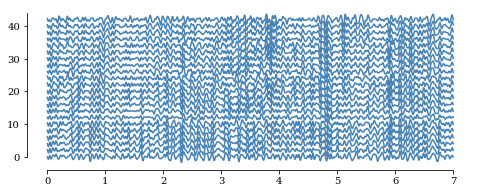

In [243]:
fig, ax = plt.subplots(figsize=(8,3))
for i in range(22):
    plt.plot(np.linspace(0, 7, len(X[1,i])), i*2+X[0,i], color="steelblue")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds(0, 7)
ax.spines['left'].set_bounds(0, 44)

plt.savefig("figures/windowed.png")


In [5]:
samples, targets = getSamples(X, y, 20, "eog", 11000)
print(samples.shape)
print(np.shape(np.ravel(targets)))

(320, 22, 1000)
(320,)


In [6]:
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

covs = Covariances()
ts = TangentSpace()

X_cov = covs.transform(samples)
ts.fit(X_cov)
X_ts = ts.transform(X_cov)
print(X_cov.shape)
print(X_ts.shape)

(320, 22, 22)
(320, 253)


In [7]:
from sklearn.tree import DecisionTreeClassifier as DTC


(-49.95, 1048.95, -4.580379984454738, 47.00364466678806)

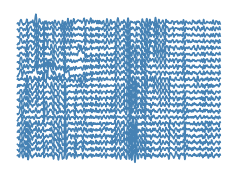

In [8]:
fig, ax = plt.subplots(figsize=(4,3))
for i in range(22):
    plt.plot(i*2+samples[2,i], color="steelblue")

#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_bounds(False)
#ax.spines['left'].set_bounds(False)
plt.axis("off")

#plt.savefig("figures/sampOrig.png")

In [29]:
samples.shape

(160, 22, 1000)